In [502]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
import json
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE

In [493]:
def run_trial(data, train_split= .9, units= 128, hidden=None, **kwargs):
    
    transformed_data, scalers = transform_data(data= data)

    
    (samples, timesteps, features) = data.shape

    # Selecting Data for Training
    train_size = int(samples * train_split)
    input_shape = (timesteps-1, features)

    x_train, x_test = transformed_data[:train_size,:-1], transformed_data[train_size:, :-1]
    y_train, y_test = transformed_data[:train_size,-1,:].reshape(train_size,1,features), transformed_data[train_size:, -1]
    
    
    # Modelling
    history, model = LSTMModel(x_train, y_train, input_shape, hidden= hidden, units= units, **kwargs)
    
    
    y_pred, y_true = untransform_data( model.predict(x_test), x_test, y_test, scalers)
    
    return history, model, y_pred, y_true

In [342]:
def transform_data(data):
    """ Transforms data for LSTM selection """

    # Scaling the data to between 0 & 1
    data = np.array(data)
    transformed = []
    scalers = []
    for sample in data:
        scaler = MinMaxScaler()
        transformed.append(scaler.fit_transform(sample))
        scalers.append(scaler)
        
    transformed_data = np.array(transformed)

    return transformed_data, scalers

In [492]:
# Model imported from LSTM
def LSTMModel(x_train, y_train, input_shape, 
                  optimizer='adam', loss= 'mae', units= 128, epochs= 25, 
                  verbose= 1, validation_split= 0.05, batch_size= 1, hidden= None,
                  **kwargs):
    
    
    model = Sequential()


    
    if hidden is not None:
        model.add( LSTM(units= units, input_shape = (input_shape), return_sequences=True) )


        model.add( LSTM(units= hidden ))
        
    else:
        model.add( LSTM(units= units, input_shape = (input_shape)) )



    model.add( Dense(units = input_shape[-1]) )

    model.compile(optimizer=optimizer, loss=loss)
    


    history = model.fit(x_train, y_train, 
                            batch_size= batch_size, epochs= epochs, verbose= verbose, 
                            validation_split= validation_split, 
                        **kwargs)
    
    return history, model

In [337]:
def untransform_data(predictions, x_test, y_test, scalers):
    """ Function to transform the output predictions from the normalized LSTM-space, to the real space """
    
    pred_untransformed = []
    true_untransformed = []
    
    pred_and_test = np.append(x_test,predictions.reshape(x_test.shape[0], 1, x_test.shape[2]), axis=1)
    true_and_test = np.append(x_test,y_test.reshape(x_test.shape[0], 1, x_test.shape[2]), axis=1)

    train_size = x_train.shape[0]
    
    for i in range(x_test.shape[0]):
        pred_untransformed.append( scalers[train_size+i].inverse_transform(pred_and_test[i]) )
        true_untransformed.append( scalers[train_size+i].inverse_transform(true_and_test[i]) )

    pred_untransformed = np.array(pred_untransformed)
    true_untransformed = np.array(true_untransformed)
    return pred_untransformed, true_untransformed

## Importing and Properly Modifying Data

In [338]:
rawdata = {}

datapath = r'./data/reshaped/'

for file in os.listdir(datapath):
    with open(datapath + file) as f:
        rawdata[file.split('.')[0]] = json.load(f)
        
t = []
for i, sample in enumerate(rawdata['2012q1']['index']):
    t.append([])
    for timestep in rawdata.keys():
        t[i].append(rawdata[timestep]['data'][i])

data = np.nan_to_num(np.array(t).astype('float32'))

## Generating frequency Plot & Selecting Most Frequent Columns

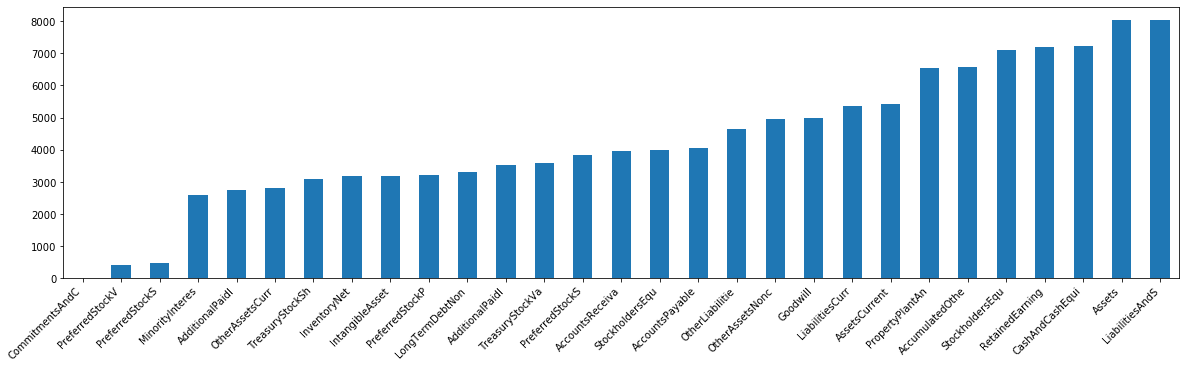

In [339]:
freq_df = pd.Series(index= rawdata['2012q1']['columns'], data= np.count_nonzero(data, axis=(0,1)))
    
freq_df.index = freq_df.index.str.extract(r'(.{0,15})')[0].values

most_freq_features = np.ravel(np.argwhere(freq_df.index.isin(freq_df.sort_values()[-5:].index)))

freq_df.sort_values().plot.bar(figsize=(20,5))

plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

## Running the model

In [508]:
trials={
#     1: {'loss': 'MAE', 'units': 128, 'hidden': None, 'epochs': 25},
#     2: {'loss': 'MAPE'},
#     3: {'units': 256, 'loss': 'MAE'},
#     4: {'units': 256, 'loss': 'MAPE'},
#     5: {'units': 384, 'loss': 'MAE', 'hidden': None},
#     6: {'units': 128, 'loss': 'MAE', 'hidden': 128},
#     7: {'loss': 'MAE'},
#     8: {'loss': 'MAE', 'units': 64},
#     9: {'loss', 'MAE', 'units': 100},
    10: {'units': 1, 'epochs': 2},
}

In [ ]:
for trial in trials:

    print(trial)
    
    results[trial] = {}
    MAE_total = 0


    for i in range(10):
        
        
        history, model, y_pred, y_true = run_trial(data[:,:,most_freq_features], train_split= .95,  verbose= 1, 
                                               **trials[trial])
        
        MAE_temp = MAE(y_true[:,-1,:], y_pred[:,-1,:])
        
        MAE_total += MAE_temp
        
        if i == 0:
            MAE_min = MAE_temp
            results[trial]['history'] = history
            results[trial]['model'] = model
            results[trial]['y_pred'] = y_pred
            results[trial]['y_true'] = y_true
    
        elif MAE_temp < MAE_min:
            MAE_min = MAE_temp
            results[trial]['history'] = history
            results[trial]['model'] = model
            results[trial]['y_pred'] = y_pred
            results[trial]['y_true'] = y_true
        
        
        print("i:%d\tMAE:%.2e" % (i, MAE_temp))
    results[trial]['MAE'] = MAE_total/i
            
    

10
Train on 227 samples, validate on 12 samples
Epoch 1/2
227/227 [==============================] - 5s 20ms/sample - loss: 0.5117 - val_loss: 0.4127
Epoch 2/2
227/227 [==============================] - 3s 11ms/sample - loss: 0.3358 - val_loss: 0.3254
i:0	MAE:2.07e+09
Train on 227 samples, validate on 12 samples
Epoch 1/2
227/227 [==============================] - 4s 19ms/sample - loss: 0.5635 - val_loss: 0.5427
Epoch 2/2
227/227 [==============================] - 3s 11ms/sample - loss: 0.4697 - val_loss: 0.4671
i:1	MAE:4.45e+09
Train on 227 samples, validate on 12 samples
Epoch 1/2
227/227 [==============================] - 5s 20ms/sample - loss: 0.5036 - val_loss: 0.4625
Epoch 2/2
227/227 [==============================] - 3s 12ms/sample - loss: 0.3848 - val_loss: 0.3851
i:2	MAE:4.52e+09
Train on 227 samples, validate on 12 samples
Epoch 1/2
227/227 [==============================] - 5s 22ms/sample - loss: 0.5688 - val_loss: 0.5632
Epoch 2/2
227/227 [==============================] -

Prediction Error 5.47e+08, CF-Error 7.34e+08
Prediction Error 7.26e+09, CF-Error 7.34e+08
Prediction Error 7.83e+08, CF-Error 7.34e+08
Prediction Error 7.11e+09, CF-Error 7.34e+08
Prediction Error 6.69e+08, CF-Error 7.34e+08
Prediction Error 6.09e+08, CF-Error 7.34e+08
Prediction Error 5.13e+08, CF-Error 7.34e+08
Prediction Error 6.29e+08, CF-Error 7.34e+08


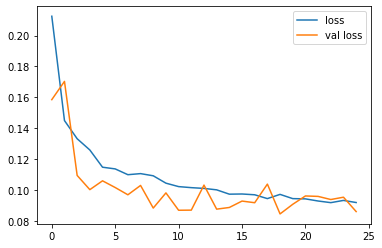

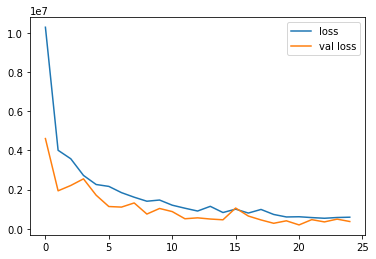

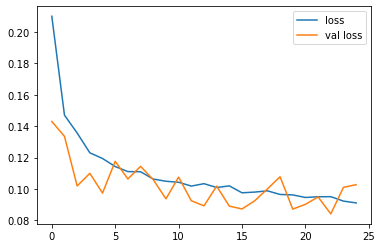

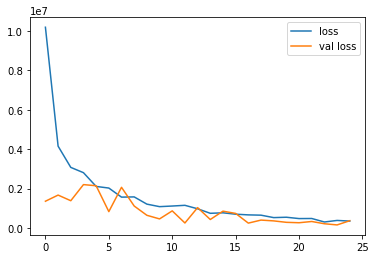

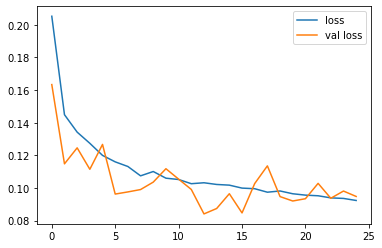

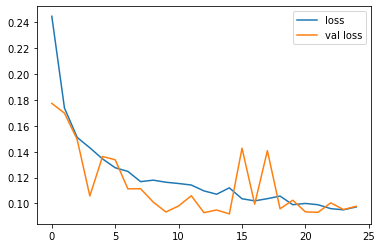

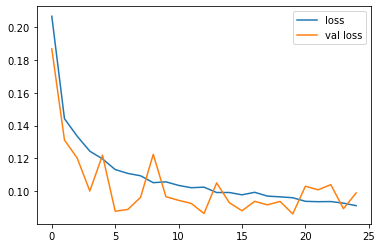

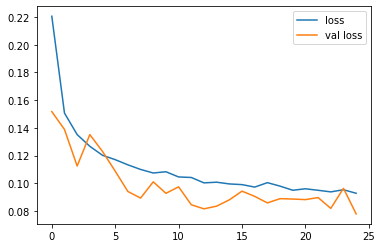

In [501]:
for trial in results:
    plt.figure()
    plt.plot(results[trial]['history'].history['loss'], label='loss')
    plt.plot(results[trial]['history'].history['val_loss'], label='val loss')
    plt.legend()
    
    y_pred = results[trial]['y_pred']
    y_true = results[trial]['y_true']
    
    print("Prediction Error %.2e, CF-Error %.2e" % (
          metrics.mean_absolute_error(y_true[:,-1,:], y_pred[:,-1,:]),
          metrics.mean_absolute_error(y_true[:,-1,:], y_true[:,-2,:])))


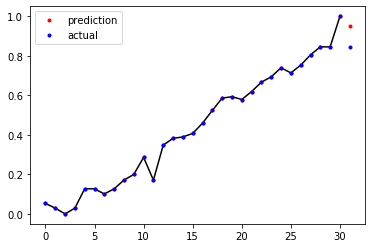

In [367]:
plot_index = (2,5)

fig, ax = plt.subplots()

ax.plot(y_true[plot_index[0],:-1,plot_index[1]], '-k')
ax.plot(y_pred[plot_index[0],:,plot_index[1]], '.r', label='prediction')
ax.plot(y_true[plot_index[0],:,plot_index[1]], '.b', label='actual')
ax.legend()
# y_pred[0,:,5]